# Unsupervised Learning Lab

In this lab you will work through several examples of methods and applications of unsupervised learning. We will be working with the **Digits** dataset of of handwritten numbers. This dataset is convenient because Scikit-learn provides it built-in.

**NOTE**: I do not explicitly *ask* for your analyses in this notebook, but you should definitely provide them!

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.datasets import load_digits

# variable for the whole laboratory to visualize or not graphs and results
wantToDisplay = False

# Load the digits dataset and extract data and labels.
ds = load_digits() # each datapoint is a 8x8 image of a digit
Xs = ds.data
ys = ds.target

# Dataset has 1797 samples, each image is composed of 64 pixels
print(ds.data.shape)

# Some examples of images present in the dataset
if wantToDisplay:
    for i in [0, 11, 50, 100]:
        plt.gray()
        plt.matshow(ds.images[i])
        plt.show()

(1797, 64)


## 1. Clustering
In this set of exercises we will experiment with clustering of the digits dataset.

### Exercise 1.1: K-means clustering
Use K-means clustering to cluster the digits dataset into 10 clusters (i.e. the "*correct*" number of clusters). After clustering the data, for each cluster center compute the sum-of-squared-distances to it and all points assigned to its cluster. This is called the cluster *inertia* and is a measure of cluster compactness.

Inertia per cluster 1165210.5309185907

Another version of inertia per cluster 1165210.5309185907

Inertia of the model 1165210.5309185905


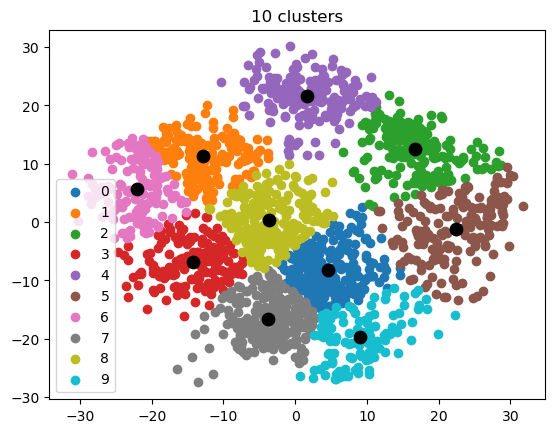

In [2]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# k-means model with 10 clusters to form as well as 10 centroids to generate
model = KMeans(n_clusters = 10)

# computing k-means clustering
model.fit(Xs)

def inertia_per_cluster(Xs, model):
    inertias = []
    for (i, center) in enumerate(model.cluster_centers_):
        # sum of squared distances
         inertias.append(np.sum((Xs[model.labels_ == i] - center)**2.0))
    return np.array(inertias)

def ipc(Xs, model):
    return [((Xs[model.labels_ == i] - c)**2.0).sum() for (i, c) in enumerate(model.cluster_centers_)]

def plotting(Xs, model):
    pca = PCA(2)
    df = pca.fit_transform(Xs)
    label = model.fit_predict(df)
    u_labels = np.unique(label)
    centroids = model.cluster_centers_
    
    for i in u_labels:
        plt.scatter(df[label == i , 0] , df[label == i , 1] , label = i)
    plt.scatter(centroids[:,0] , centroids[:,1] , s = 80, color = 'k')
    plt.legend()
    plt.title('10 clusters')
    plt.show()

# these are not always the same because non necessarily they start from the same point
print("Inertia per cluster", np.sum(inertia_per_cluster(Xs, model)))
print()

print("Another version of inertia per cluster", np.sum(np.array(ipc(Xs, model))))
print()

print("Inertia of the model", model.inertia_)

# plotting the data based on the cluster
plotting(Xs, model)

### Exercise 1.2: Transforming our clustering into a classifier
Now use the labels in `ys` to compute a probability distribution over all classes (i.e. a *histogram*) for each cluster. 

Write a function that, given a test sample $\mathbf{x}$, returns the class with maximum likelihood given by the closest cluster center. 

Evaluate your classifier. 

Compute the entropy for each cluster based on your estimated probability distribution. Does the entropy of a cluster correlate to misclassifications of test samples closest to it?

**Note**: since you will be testing this classifier, you will want to carefully split the data into *training* and *test* splits.

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics.cluster import adjusted_rand_score
import math

X_train, X_test, y_train, y_test = train_test_split(Xs, ys, train_size=0.7)

# define number of classes for our data and clusters to compute
n_clusters = 10
n_classes = 10

def kmeansFit(X, n_clusters):
    km_model = KMeans(n_clusters = n_clusters)
    km_model.fit(X)
    return km_model

# we want a distribution of classes for each cluster
def getDistribution(model, ys, n_clusters, n_classes, display = True):    
    # labels is the index of the cluster each sample belongs to
    labels = model.labels_
    probability_distr = np.zeros((n_clusters, n_classes))
    cluster_val = np.arange(n_clusters)
    for i in range (len(labels)):
        temp = ys[i]
        cl = labels[i]
        probability_distr[cl, temp] += 1    
    # a plot for each cluster
    if display:
        for c in range (n_clusters):
            plt.figure(figsize = (2, 2))
            plt.title(f'Cluster: {c}')
            plt.bar(cluster_val, probability_distr[c])
            # there will always be 1 hist with values of class 1 and 8 really high, so it will missclassify '1' as '8'
            plt.show()
    return probability_distr
    
def getLabels(probability_distr, n_clusters, n_classes):
    # dictionary with key=cluster and value=class
    labeling = {}
    for i in range (n_clusters):
        index = np.argmax(probability_distr[i])
        labeling[i] = index
    return labeling
        
def checkAccuracy(X_test, y_test, model, display = True):
    acc = accuracy_score(y_test, model.predict(X_test))
    ars = adjusted_rand_score(y_test, model.predict(X_test))

    if display:
        # accuracy is NOT good because it compares cluster index to class index
        print('Model accuracy based on indices is:', acc*100,'%')
        print(classification_report(y_test, model.predict(X_test)))
        print('Model accuracy is:', ars*100,'%')   
    return ars

def checkEntropy(n_clusters, pr_distr, display = True):
    total_entropy = 0
    for i in range (n_clusters):
        entropy_cluster = 0
        points_in_cluster = 0
        for j in range (len(pr_distr[i])):
            points_in_cluster += pr_distr[i, j]
        for k in range (len(pr_distr[i])):
            temp = pr_distr[i, k]/points_in_cluster
            entropy_cluster += temp * math.log2(temp + 0.00000001)
        if display:
            print('Entropy of cluster', i, 'is', -entropy_cluster)
        total_entropy += entropy_cluster
    if display:
        print('Total entropy is', -total_entropy)

# 1. PROBABILITY DISTRIBUTION
# fitting on the whole dataset
model_total = kmeansFit(Xs, n_clusters)
getDistribution(model_total, ys, n_clusters, n_classes, wantToDisplay) # followed by getLabel if I want to have the dict of labels

# 2. ML BASED ON CLOSEST CLUSTER CENTER
# fitting on 70% training data
model_train = kmeansFit(X_train, n_clusters)
# for kmeans algorithm x test should be assigned the label of the closest cluster center
# this is exactly what predict does "Predict the closest cluster each sample in X belongs to"
y_pred = model_train.predict(X_test)

# 3. EVALUATING THE CLASSIFIER
checkAccuracy(X_test, y_test, model_train, wantToDisplay)

# 4. CALCULATING ENTROPY FOR EACH CLUSTER
# if we look at these histograms we can see the entropy for each cluster
pr_distr = getDistribution(model_train, y_train,n_clusters, n_classes, wantToDisplay)
checkEntropy(n_clusters, pr_distr, wantToDisplay)
# some clusters have quite a high entropy as seen from the last function, because of it some test samples can get misclassified 
getLabels(pr_distr, n_clusters, n_classes)

# the memory leak error shouldn't cause any problems in our case since the dataset is not big enough

C:\Users\mo4al\anaconda3\envs\FML\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


{0: 3, 1: 0, 2: 5, 3: 4, 4: 6, 5: 2, 6: 7, 7: 9, 8: 1, 9: 1}

## 2. Gaussian Mixture Models and Expectation Maximization
In this set of exercises we will experiment with fitting a Gaussian Mixture Model (GMM) to the digits dataset.  

### Exercise 2.1: Fitting a GMM
Fit a GMM (using `sklearn.mixture.GaussianMixture`) with 10 mixture components to the digits dataset. 

In [4]:
from sklearn.mixture import GaussianMixture

n_components = 10
n_classes = 10
X_train, X_test, y_train, y_test = train_test_split(Xs, ys, train_size=0.7)

def gmFit (Xs, ys, n_comp):
    model = GaussianMixture(n_components = n_comp)
    model.fit(Xs)
    labels = model.predict(Xs)
    return model, labels

gm_model, labels = gmFit(X_train,y_train, n_components)

# the memory leak error shouldn't cause any problems in our case since the dataset is not big enough

C:\Users\mo4al\anaconda3\envs\FML\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


### Exercise 2.2: Transforming the GMM into a classifier
Use the `predict_proba()` method of your fit GMM to obtain the probability distribution over the mixture components for all samples in the training set. Use these, together with the true labels `ys`, to construct a classifier. 

Evaluate your classifier. 

Repeat the experiment with more mixture components.

In [11]:
def gmDistribution(Xs, ys, n_components, n_classes, label, display = True):
    probability_distr = np.zeros((n_components, n_classes))
    total_tr_samples = len(gm_model.predict(Xs))
    component_val = np.arange(n_components)
    
    # computing probability distibution
    for i in range (len(label)):
        temp = ys[i]
        cl = label[i]
        probability_distr[cl, temp] += 1   
    # plotting the histograms
    if display:
        for c in range (n_components):
            plt.figure(figsize = (2, 2))
            plt.title(f'Component: {c}')
            plt.bar(component_val, probability_distr[c])
            plt.show()
    return probability_distr

def gmClassifier(X_ts, y_ts, model, distrib, display = True):
    # computing maximum class d
    max_distrib = np.zeros(n_components)    
    for i in range(n_components):
        max_distrib[i] = np.amax(distrib[i])
    
    # variables to see if the decisions are the same
    good_class = 0
    bad_class = 0
        
    for j in range (len(X_ts)):
        x = X_ts[j].reshape(1, -1)
        # this is the value we get making a HARD decision
        y_pr = model.predict(x)
        
        # for SOFT decision we need to compute maximum of (predict_proba of class i)*(distribution of class i)
        comp_pr = gm_model.predict_proba(x) + 0.00000001
        max_pr = 0
        max_index = 0
        for k in range (n_components):
            temp = comp_pr[:, k] * max_distrib[k]
            if (temp > max_pr):
                max_pr = temp
                max_index = k
        
        if (y_pr != max_index):
            bad_class += 1
        else:
            good_class += 1
    if display:       
        print('The classification was the same in', good_class, 'cases, but was not in', bad_class,'cases')
    good_acc = good_class/(good_class+bad_class)
    #return good_acc

n_components = 10
probability_distr_gm = gmDistribution(X_train, y_train, n_components, n_classes, labels, wantToDisplay)
labeling10 = getLabels(probability_distr_gm, n_components, n_classes)
# we can see that the precision, recall and f1 score for some components is 0, because it's data is missclassified
# we can see a confirmation of that in getLabels function because to different label corresponds the same class
checkAccuracy(X_test, y_test, gm_model, wantToDisplay)

gmClassifier(X_test, y_test, gm_model, probability_distr_gm, wantToDisplay)


# if we change the number of components
change_components = True
X_train, X_test, y_train, y_test = train_test_split(Xs, ys, train_size=0.7)
if change_components:
    best_acc = 0
    best_comp = 0
    for n in range(1, 100, 9):
        n_components = n
        gm_model_new, labels_new = gmFit(X_train,y_train, n_components)
        probability_distr_gm_new = gmDistribution(X_train, y_train, n_components, n_classes, labels_new, False)
        labeling = getLabels(probability_distr_gm_new, n_components, n_classes)
        new_acc = checkAccuracy(X_test, y_test, gm_model_new, False)
        if (new_acc > best_acc):
            best_acc = new_acc
            best_comp = n
            # the best is 10, it makes sense because we have 10 classes
    print('The number of components for best accuracy is', best_comp)

C:\Users\mo4al\anaconda3\envs\FML\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\mo4al\anaconda3\envs\FML\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\mo4al\anaconda3\envs\FML\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\mo4al\anaconda3\envs\FML\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is k

The number of components for best accuracy is 10


### Exercise 2.3: Sampling from the GMM
Use the `sample()` method on a GMM fit to the digits data to generate random samples from the learned distribution. Visualize these samples in the original feature space. Are there some digits better reconstructed than others? How might you determine *which* ones are better captured?

In [13]:
(sample, components) = gm_model.sample(10)

def showImages (labeling10, display = True):
    if display:
        print(labeling10)
        for (s, c) in zip(sample, components):
            plt.figure(figsize = (1, 1))
            plt.imshow(s.reshape((8, 8)))
            plt.title(f'Component: {c}')
            plt.show()

# from these images we can deduce which component corresponds to which digit
showImages(labeling10, wantToDisplay)

# To determine which digits are better captured we need to see more samples and see if their labels correspond to the true class label

C:\Users\mo4al\anaconda3\envs\FML\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[[0.00000000e+00 2.82678754e-01 7.01754812e+00 1.31660738e+01
  1.27986393e+01 6.87971881e+00 8.93971937e-01 7.06696857e-03
  0.00000000e+00 3.12715757e+00 1.41590068e+01 9.45238153e+00
  1.00460543e+01 1.06994871e+01 1.66780537e+00 3.53348428e-03
  0.00000000e+00 3.67494299e+00 1.08693317e+01 4.30029816e+00
  7.86236085e+00 9.81602067e+00 1.55826707e+00 0.00000000e+00
  0.00000000e+00 1.91175813e+00 8.52663154e+00 1.15405509e+01
  1.32120090e+01 9.61461157e+00 1.59713496e+00 0.00000000e+00
  0.00000000e+00 3.85149787e-01 3.20150389e+00 6.93307814e+00
  9.25801638e+00 1.15262502e+01 3.40627887e+00 0.00000000e+00
  0.00000000e+00 1.23671969e-01 2.20845192e+00 2.05331240e+00
  2.98250019e+00 1.19929566e+01 5.77373748e+00 0.00000000e+00
  0.00000000e+00 7.80900097e-01 7.52995104e+00 5.99309985e+00
  6.75258485e+00 1.31307386e+01 4.77388067e+00 0.00000000e+00
  0.00000000e+00 2.04942104e-01 7.29664580e+00 1.41306675e+01
  1.41908557e+01 8.28635511e+00 9.85866083e-01 0.00000000e+00]
 [0.000

## 3. Principal Component Analysis
In this set of exercises we will see how Principal Component Analysis (PCA) can be used to *simplify* the representation of input data in order to make visualize them or to make learning more stable. 

### Exercise 3.1: Fitting a Bayesian Generative Model

Fit a *Quadratic* generative model (e.g. `sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis()`) to the Digits dataset. Observe *all* warnings that the model fitting procedure returns. How well does the trained model work?

**Note**: Since we are using a *supervised* model as a downstream task, you should *split* the dataset into training and test sets. 

In [7]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

X_train, X_test, y_train, y_test = train_test_split(Xs, ys, train_size=0.75)

max_acc = 0
max_index = 0
min_acc = 1
# sometimes with pca in 47 components the variables are collinear
for i in range(2, 48):
    pca = PCA(n_components = i)
    pca.fit(X_train)
    qdc = QuadraticDiscriminantAnalysis()
    qdc.fit(pca.transform(X_train), y_train)
    acc = accuracy_score(y_test, qdc.predict(pca.transform(X_test)))
    # to see the maximum accuracy and its index
    if acc > max_acc:
        max_acc = acc
        max_index = i
    # to see minimum accuracy
    if acc < min_acc:
        min_acc = acc

print('We get the best accuracy at', max_index,'components. Value of that accuracy is', round(max_acc*100, 3), '%')

We get the best accuracy at 19 components. Value of that accuracy is 98.444 %


## Exercise 3.2: Removing "redundant" dimensions

Use *Principal Component Analysis (PCA)* to reduce the dimensionality of the digits dataset. You can use `sklearn.decomposition.PCA` for this. You should think carefully about how to choose the *number* of principal components to use. You should also think *very carefully* about which data is used to estimate the principal components. Use the transformed dataset to train and test a Bayes Quadratic classifier.

In [8]:
def decomp(max_i, display = True):
    max_cv = []
    for i in range(2, 50):
        pca = PCA(n_components = i)
        pca.fit(X_train)
        evr = pca.explained_variance_ratio_
        cv = np.cumsum(evr*100)
        max_cv.append(np.max(cv)) 
    # plotting
    if display:
        plt.plot(max_cv)
        plt.show()
    # checking the value of cv for the index that had the best accuracy in the exercise above
    print('Cumulative variance for', max_i, ' is ', round(max_cv[max_i], 4))

decomp(max_index, wantToDisplay)
# we can see from the plot that already at 25 components we have quite a high cumulative explaned variable ratio
# this means we should use a model that has:
    # the highest accuracy 
    # thehighest evr but it also 
    # should NOT have collinear variables

Cumulative variance for 19  is  90.4075


### Exercise 3.3: PCA as a visualization tool

Transform the Digits dataset onto only *two* dimensions and visualize the dataset using a scatterplot. You can use `ys` to *color* the points in the scatterplot according to the true classes. Do the classes form natural clusters? Do some of them?

In [9]:
from mpl_toolkits import mplot3d

def dim2Plot(display = True):
    pca = PCA(n_components = 2)
    pca.fit(Xs)
    Xs2d = pca.transform(Xs)
    if display:
        plt.title("2D scatter plot")
        plt.scatter(Xs2d[:, 0], Xs2d[:, 1], c = ys, cmap = 'hot')
        plt.show()

def dim3Plot(display = True):
    pca_3d = PCA(n_components = 3)
    pca_3d.fit(Xs)
    Xs3d = pca_3d.transform(Xs)
    if display:
        plt.figure(figsize = (10, 10))
        ax = plt.axes(projection = "3d")
        ax.scatter3D(Xs3d[:, 0], Xs3d[:, 1], Xs3d[:, 2], c = ys, cmap = 'hot')
        plt.title("3D scatter plot")
        ax.set_xlabel ('Component 1')
        ax.set_ylabel ('Component 2')
        ax.set_zlabel ('Component 3')
        plt.show()

dim2Plot(wantToDisplay)
dim3Plot(wantToDisplay)

# in 3 dimensions the clusters are more obvious, in 2 dimensions they seem more like one on top of the other

### Exercise 3.4: TSNE for *better* visualization
PCA is severely limited by the fact that it finds a *linear* manifold of the original data. Use `sklearn.manifold.TSNE` instead to learn a 2-dimensional *nonlinear* manifold of digits. Repeat the visualization like before.

In [10]:
from sklearn.manifold import TSNE

def dim2TSNE(X, y, display = True):
    X_emb = TSNE(n_components = 2, random_state = 0).fit_transform(X)
    if display:
        plt.scatter(X_emb[:, 0], X_emb[:, 1], c = y, cmap = 'hot')
        plt.title("2D scatter plot")
        plt.xlabel ('Component 1')
        plt.ylabel ('Component 2')
        plt.show()

def dim3TSNE(X, y, display = True):
    X_emb = TSNE(n_components = 3).fit_transform(X)
    if display:
        plt.figure(figsize = (10, 10))
        ax = plt.axes(projection = "3d")
        ax.scatter3D(X_emb[:, 0], X_emb[:, 1], X_emb[:, 2], c = y, cmap = 'hot')
        plt.title("3D scatter plot")
        ax.set_xlabel ('Component 1')
        ax.set_ylabel ('Component 2')
        ax.set_zlabel ('Component 3')
        plt.show()

# TSNE brings that neighbour relationship from 64 dimensions.
# we can see that relationship even in 2 and in 3 dimensions
dim2TSNE(Xs, ys, wantToDisplay)
dim3TSNE(Xs, ys, wantToDisplay)

C:\Users\mo4al\anaconda3\envs\FML\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\mo4al\anaconda3\envs\FML\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\mo4al\anaconda3\envs\FML\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\mo4al\anaconda3\envs\FML\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
